In [14]:
import numpy as np
import xarray as xr
import jax.numpy as jnp
from pathlib import Path
from pycorr import TwoPointCorrelationFunction
import matplotlib.pyplot as plt
import sys, os
import pandas as pd
import jax
sys.path.append("../")
from halotools.mock_observables.pairwise_velocities import mean_radial_velocity_vs_r
from cosmo_utils.knn import get_CDFkNN
#plt.style.use(['science', 'vibrant'])

In [2]:
%matplotlib inline

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from matplotlib import cm
cmap = matplotlib.colormaps.get_cmap('viridis_r')

# Ignore warning
import warnings
import logging

logging.getLogger('matplotlib').setLevel(logging.ERROR)
warnings.filterwarnings("ignore",category=matplotlib.MatplotlibDeprecationWarning)

# Get plot params

from plot_params import params
pylab.rcParams.update(params)

# Set default colors to load at will
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [5]:
def find_equally_spaced_indices(arr, n):
    sorted_indices = np.argsort(arr)
    sorted_arr = arr[sorted_indices]
    min_val, max_val = sorted_arr[0], sorted_arr[-1]
    division_points = np.linspace(min_val, max_val, n)
    closest_indices = np.searchsorted(sorted_arr, division_points)
    closest_indices = np.clip(closest_indices, 0, len(arr) - 1)
    original_indices = sorted_indices[closest_indices]
    return original_indices

In [6]:
boxsize = 1000.
r_bins = np.linspace(0.5, 150.0, 25)
r_c = 0.5*(r_bins[1:] + r_bins[:-1])
mu_bins = np.linspace(-1, 1, 201)

data_dir = Path('/n/holystore01/LABS/iaifi_lab/Lab/set-diffuser-data/')
test_halos = np.load(data_dir / 'test_halos.npy')
cosmologies = np.array(
    pd.read_csv(data_dir/ f"test_cosmology.csv").values
)[:, [0, -1]]
equally_spaced = 20
cosmologies_used = find_equally_spaced_indices(cosmologies[:,0], equally_spaced)
cosmologies = cosmologies[cosmologies_used]
test_halos = test_halos[cosmologies_used]

In [16]:
cosmologies

array([[0.1001, 0.9203],
       [0.1245, 0.9199],
       [0.1449, 0.6015],
       [0.1653, 0.6321],
       [0.1839, 0.6845],
       [0.2063, 0.6485],
       [0.2265, 0.8545],
       [0.2481, 0.7053],
       [0.2683, 0.9205],
       [0.2903, 0.6189],
       [0.3119, 0.7557],
       [0.3345, 0.6753],
       [0.3539, 0.6243],
       [0.3775, 0.9479],
       [0.3977, 0.6397],
       [0.4189, 0.6863],
       [0.4365, 0.9509],
       [0.4599, 0.7011],
       [0.4781, 0.6477],
       [0.4977, 0.8765]])

In [7]:
test_halos.shape

(20, 5000, 7)

In [8]:
def get_tpcf(pos,):
    return TwoPointCorrelationFunction(
                "smu",
                edges=(np.array(r_bins), np.array(mu_bins)),
                data_positions1=pos.T,
                engine="corrfunc",
                n_threads=2,
                boxsize=boxsize,
                los="z",
    )(ells=[0])[0]

def get_knn(pos,):
    random_pos = np.random.uniform(0, boxsize, size=pos.shape)
    return get_CDFkNN(
        r_bins,
        pos,
        random_pos,
        boxsize=boxsize,
        k= [1,5,9],
    )


def get_density_pdf(pos,mesh=jnp.array([128,128,128])):
    pos_mesh = pos / boxsize * mesh[0]
    delta = cic_paint(jnp.zeros(mesh),pos_mesh) - 1.
    return cic_read(delta, pos_mesh)

I0000 00:00:1700594816.703344 1589416 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [9]:

run_name = 'gallant-cherry-87'
velocities_run_name = 'magical-goosebump-109'
checkpoint = 225000
velocities_checkpoint = 145000 
n_repeats = 20
n_test = len(test_halos)
path_to_samples = Path(f'/n/holystore01/LABS/itc_lab/Users/ccuestalazaro/set_diffuser/samples/')
generated_samples = np.load(path_to_samples / f'{run_name}/test_samples_steps500_checkpoint{checkpoint}_equally_spaced20.npy')
velocity_generated_samples = np.load(path_to_samples / f'{velocities_run_name}/test_samples_steps500_checkpoint{velocities_checkpoint}_equally_spaced20.npy')

In [10]:
# compute 2pcfs
test_tpcfs = []
for hpos in test_halos:
    test_tpcfs.append(
        get_tpcf(hpos[...,:3])
    )
test_gen_tpcfs = []
for hpos in generated_samples:
    test_gen_tpcfs.append(
        get_tpcf(np.array(hpos))
    )

test_gen_tpcfs = np.array(test_gen_tpcfs)
test_gen_tpcfs = test_gen_tpcfs.reshape((n_test, n_repeats, -1))

In [11]:
# KNNs
test_knn = []
for hpos in test_halos:
    test_knn.append(
        get_knn(hpos[...,:3] % boxsize)
    )
test_gen_knn = []
for hpos in generated_samples:
    test_gen_knn.append(
        get_knn(hpos % boxsize)
    )
test_gen_knn = np.array(test_gen_knn)
test_gen_knn= test_gen_knn.reshape((n_test, n_repeats, 3, -1))

In [12]:
prop_cycle = plt.rcParams['axes.prop_cycle']

# Extract the colors from the prop_cycle
colors = prop_cycle.by_key()['color']

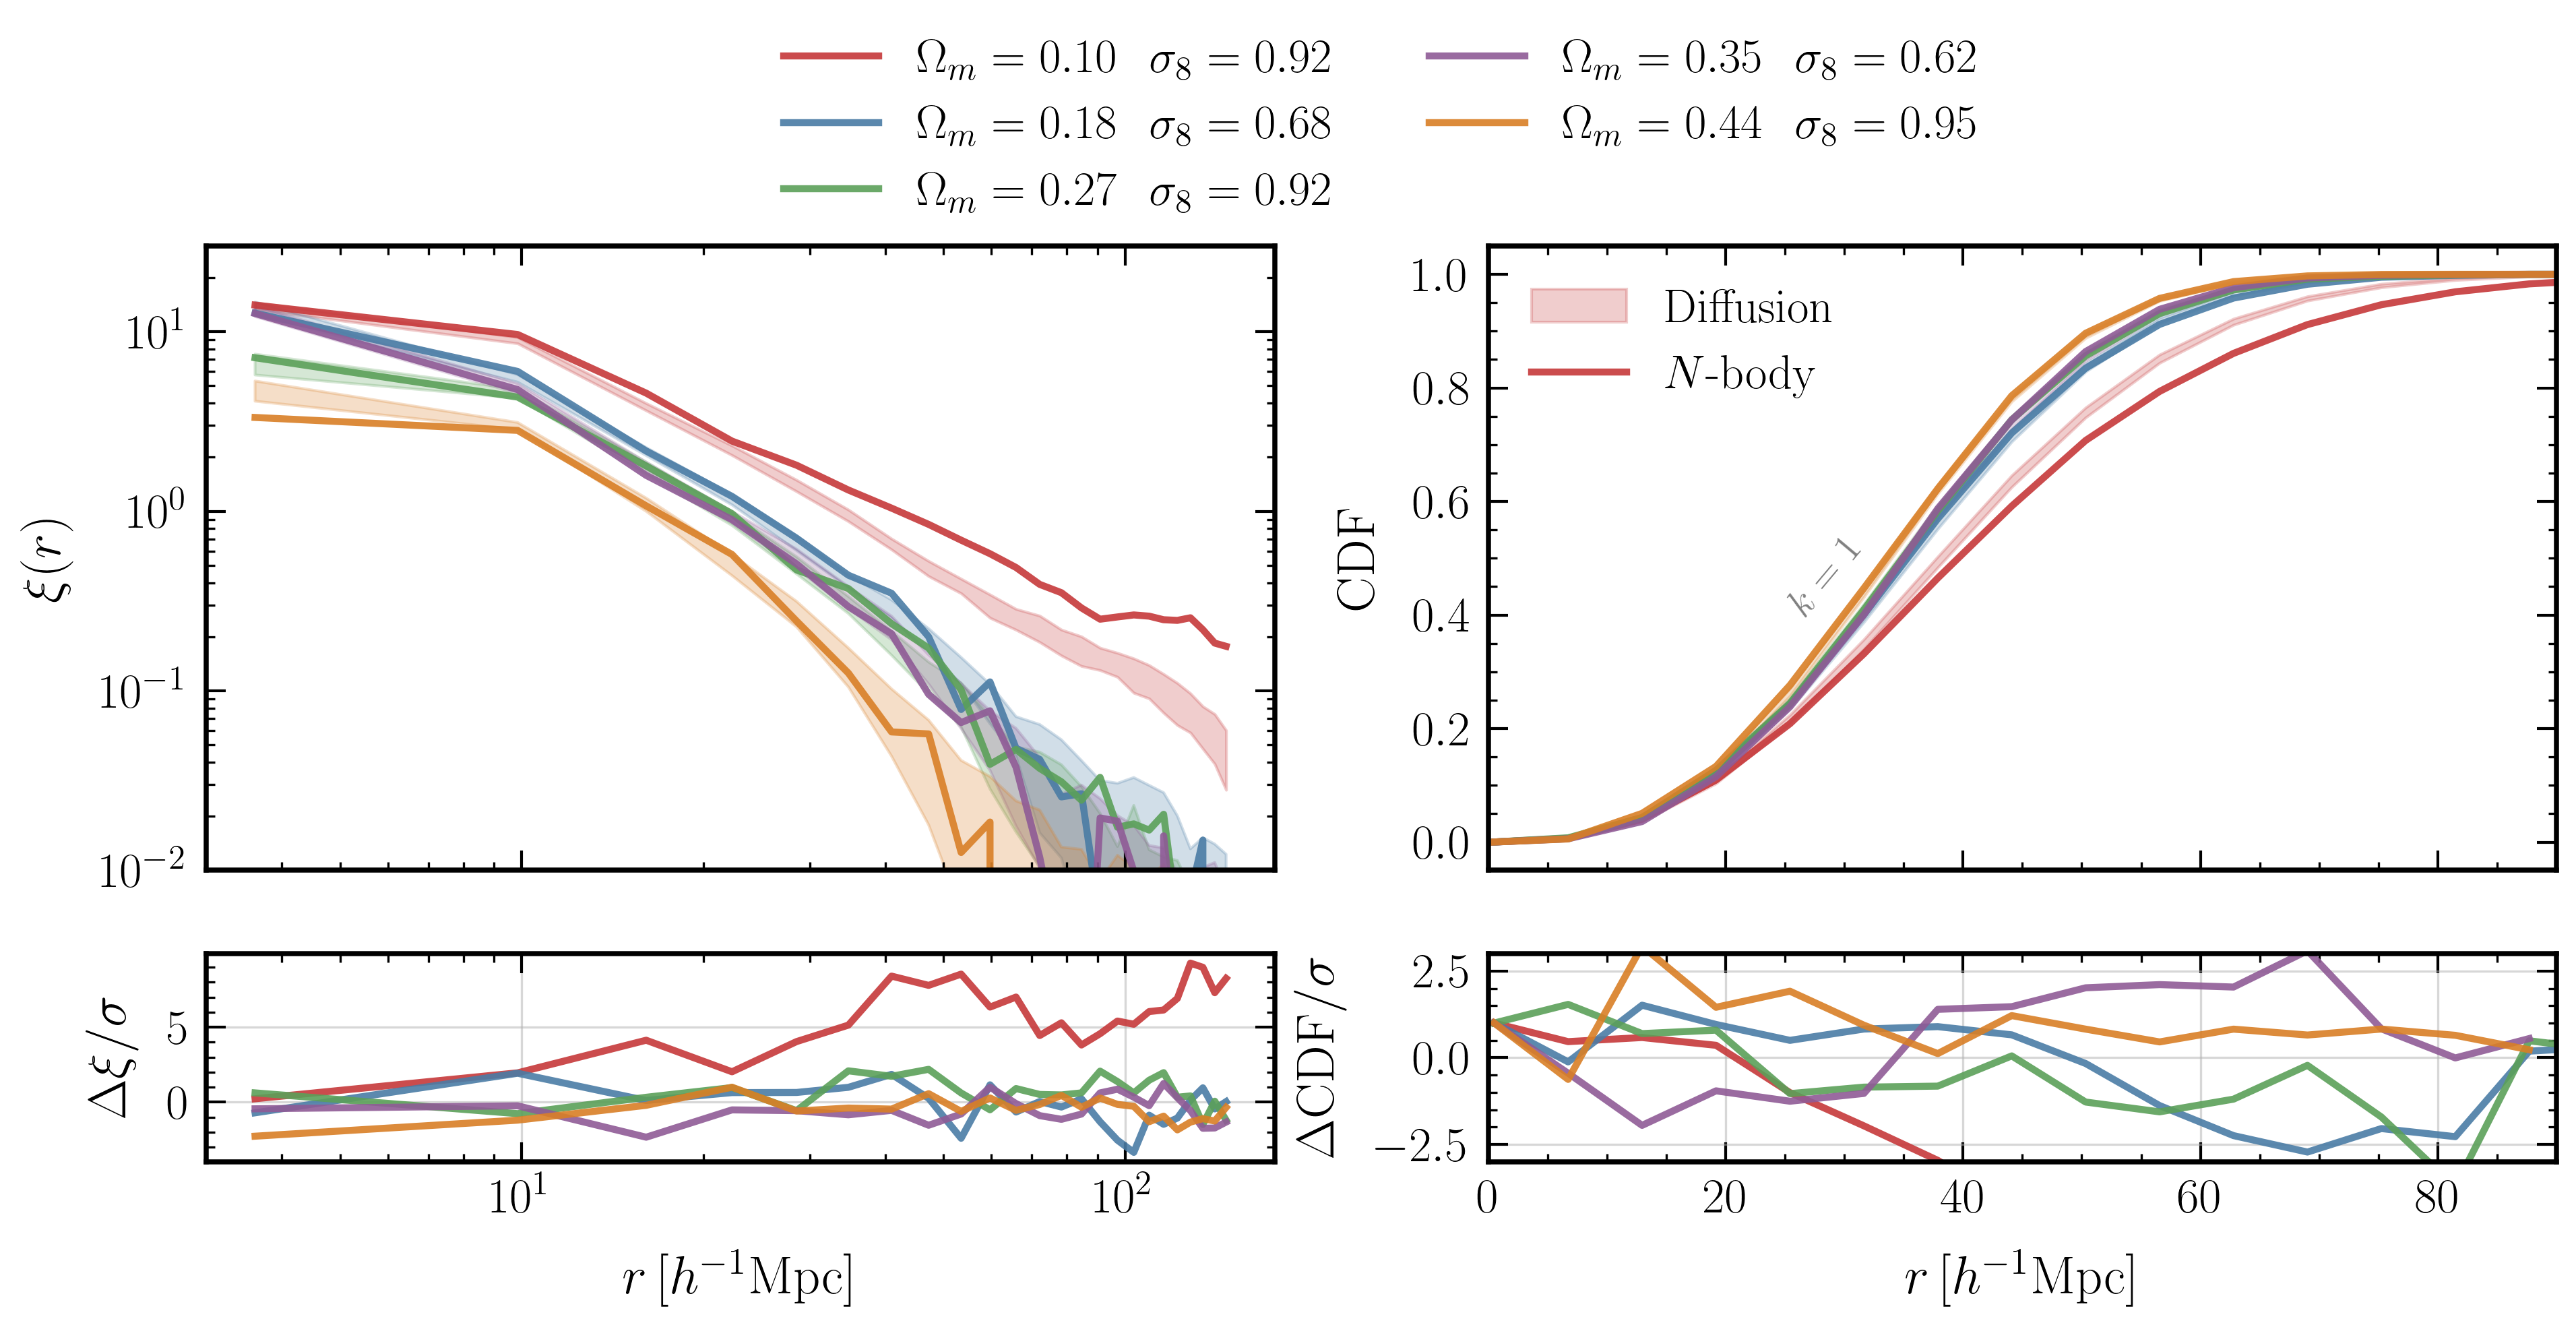

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex='col', gridspec_kw={'height_ratios': [3, 1],}, figsize=(15,6))# 'hspace':0.15},) 
k_values = [1,4,7]
for i, idx in enumerate(range(0,len(cosmologies), 4)):
    ax[0,0].fill_between(
        r_c, 
        (np.mean(test_gen_tpcfs[idx, :],axis=0) - np.std(test_gen_tpcfs[idx, :],axis=0)), 
        (np.mean(test_gen_tpcfs[idx, :],axis=0) + np.std(test_gen_tpcfs[idx, :],axis=0)), 
        alpha=0.25,
        color=colors[i],
    )
    ax[0,0].plot(r_c, test_tpcfs[idx], label= rf'$\Omega_m = {cosmologies[idx][0]:.2f} \, \, \, \,  \sigma_8 = {cosmologies[idx][1]:.2f}$', color=colors[i],)
    ax[1,0].plot(r_c, (test_tpcfs[idx]-np.mean(test_gen_tpcfs[idx, :],axis=0))/np.std(test_gen_tpcfs[idx, :],axis=0))
ax[0,0].set_yscale('log')
ax[0,0].set_xscale('log')
ax[1,0].set_xscale('log')
ax[0,0].set_ylabel(r'$\xi(r)$')
ax[1,0].set_ylabel(r'$\Delta \xi/\sigma$')
ax[0,0].set_ylim(1.e-2, 30)
ax[1,0].set_xlabel(r"$r\,[h^{-1}{\rm Mpc}]$")
ax[0,0].legend(bbox_to_anchor=(1.7,1.4),ncol=2)

k_bin = 0
for i, idx in enumerate(range(0,len(cosmologies), 4)):
    ax[0,1].fill_between(
        r_bins, 
        (np.mean(test_gen_knn[idx,:, k_bin],axis=0) - np.std(test_gen_knn[idx,:, k_bin],axis=0)),  
        (np.mean(test_gen_knn[idx, :, k_bin],axis=0) + np.std(test_gen_knn[idx,:, k_bin],axis=0)),  
        alpha=0.25,
        color=colors[i],
        label='Diffusion' if i==0 else None,
    )
    ax[0,1].plot(
        r_bins, 
        test_knn[idx][k_bin],
        color=colors[i],
        label=r'$N$-body' if i==0 else None,

    )
    ax[1,1].plot(r_bins, (test_knn[idx][k_bin]-np.mean(test_gen_knn[idx, :,k_bin],axis=0))/np.std(test_gen_knn[idx, :, k_bin],axis=0))
ax[0,1].text(25, 0.4, f'$k = {k_values[k_bin]}$', rotation=50, fontsize=14,color='gray')
ax[0,1].set_ylabel(r'$\mathrm{CDF}$')
ax[1,1].set_ylabel(r'$\Delta \mathrm{CDF}/\sigma$')
ax[1,1].set_xlabel(r"$r\,[h^{-1}{\rm Mpc}]$")
ax[1,1].set_ylim(-3,3)
ax[1,1].set_xlim(0,90)
ax[0,1].set_xlim(0,90)
ax[0,1].legend()

ax[1,0].grid(alpha=0.5)
ax[1,1].grid(alpha=0.5)
#plt.tight_layout()
plt.savefig('plots/parameter_variations.pdf', bbox_inches='tight', )

In [22]:

mass_bins =  np.linspace(14.8, 15.7, 30)
test_hmfs = []
for hpos in test_halos:
    hmf, edges = np.histogram(
        np.log10(hpos[...,-1]),
        bins=mass_bins,
    )
    hmf_flipped = np.flip(hmf)
    cumulative_hmf = np.cumsum(hmf_flipped)
    cumulative_hmf = np.flip(cumulative_hmf)
    test_hmfs.append(cumulative_hmf)



test_gen_hmfs = []
for hpos in velocity_generated_samples:
    hmf, edges = np.histogram(
        hpos[...,-1],
        bins=mass_bins,
    )
    hmf_flipped = np.flip(hmf)
    cumulative_hmf = np.cumsum(hmf_flipped)
    cumulative_hmf = np.flip(cumulative_hmf)

    test_gen_hmfs.append(cumulative_hmf)

test_gen_hmfs = np.array(test_gen_hmfs)
test_gen_hmfs = test_gen_hmfs.reshape((n_test, n_repeats, -1))

In [23]:
test_v12s = []
for hpos in test_halos:
    test_v12s.append(mean_radial_velocity_vs_r(
        hpos[...,:3],
        hpos[...,3:6],
        rbins_absolute=r_bins,
    ))
test_gen_v12s = []
for hpos in velocity_generated_samples:
    test_gen_v12s.append(mean_radial_velocity_vs_r(
        hpos[...,:3],
        hpos[...,3:6],
        rbins_absolute=r_bins,
    ))

test_gen_v12s = np.array(test_gen_v12s)
test_gen_v12s = test_gen_v12s.reshape((n_test, n_repeats, -1))




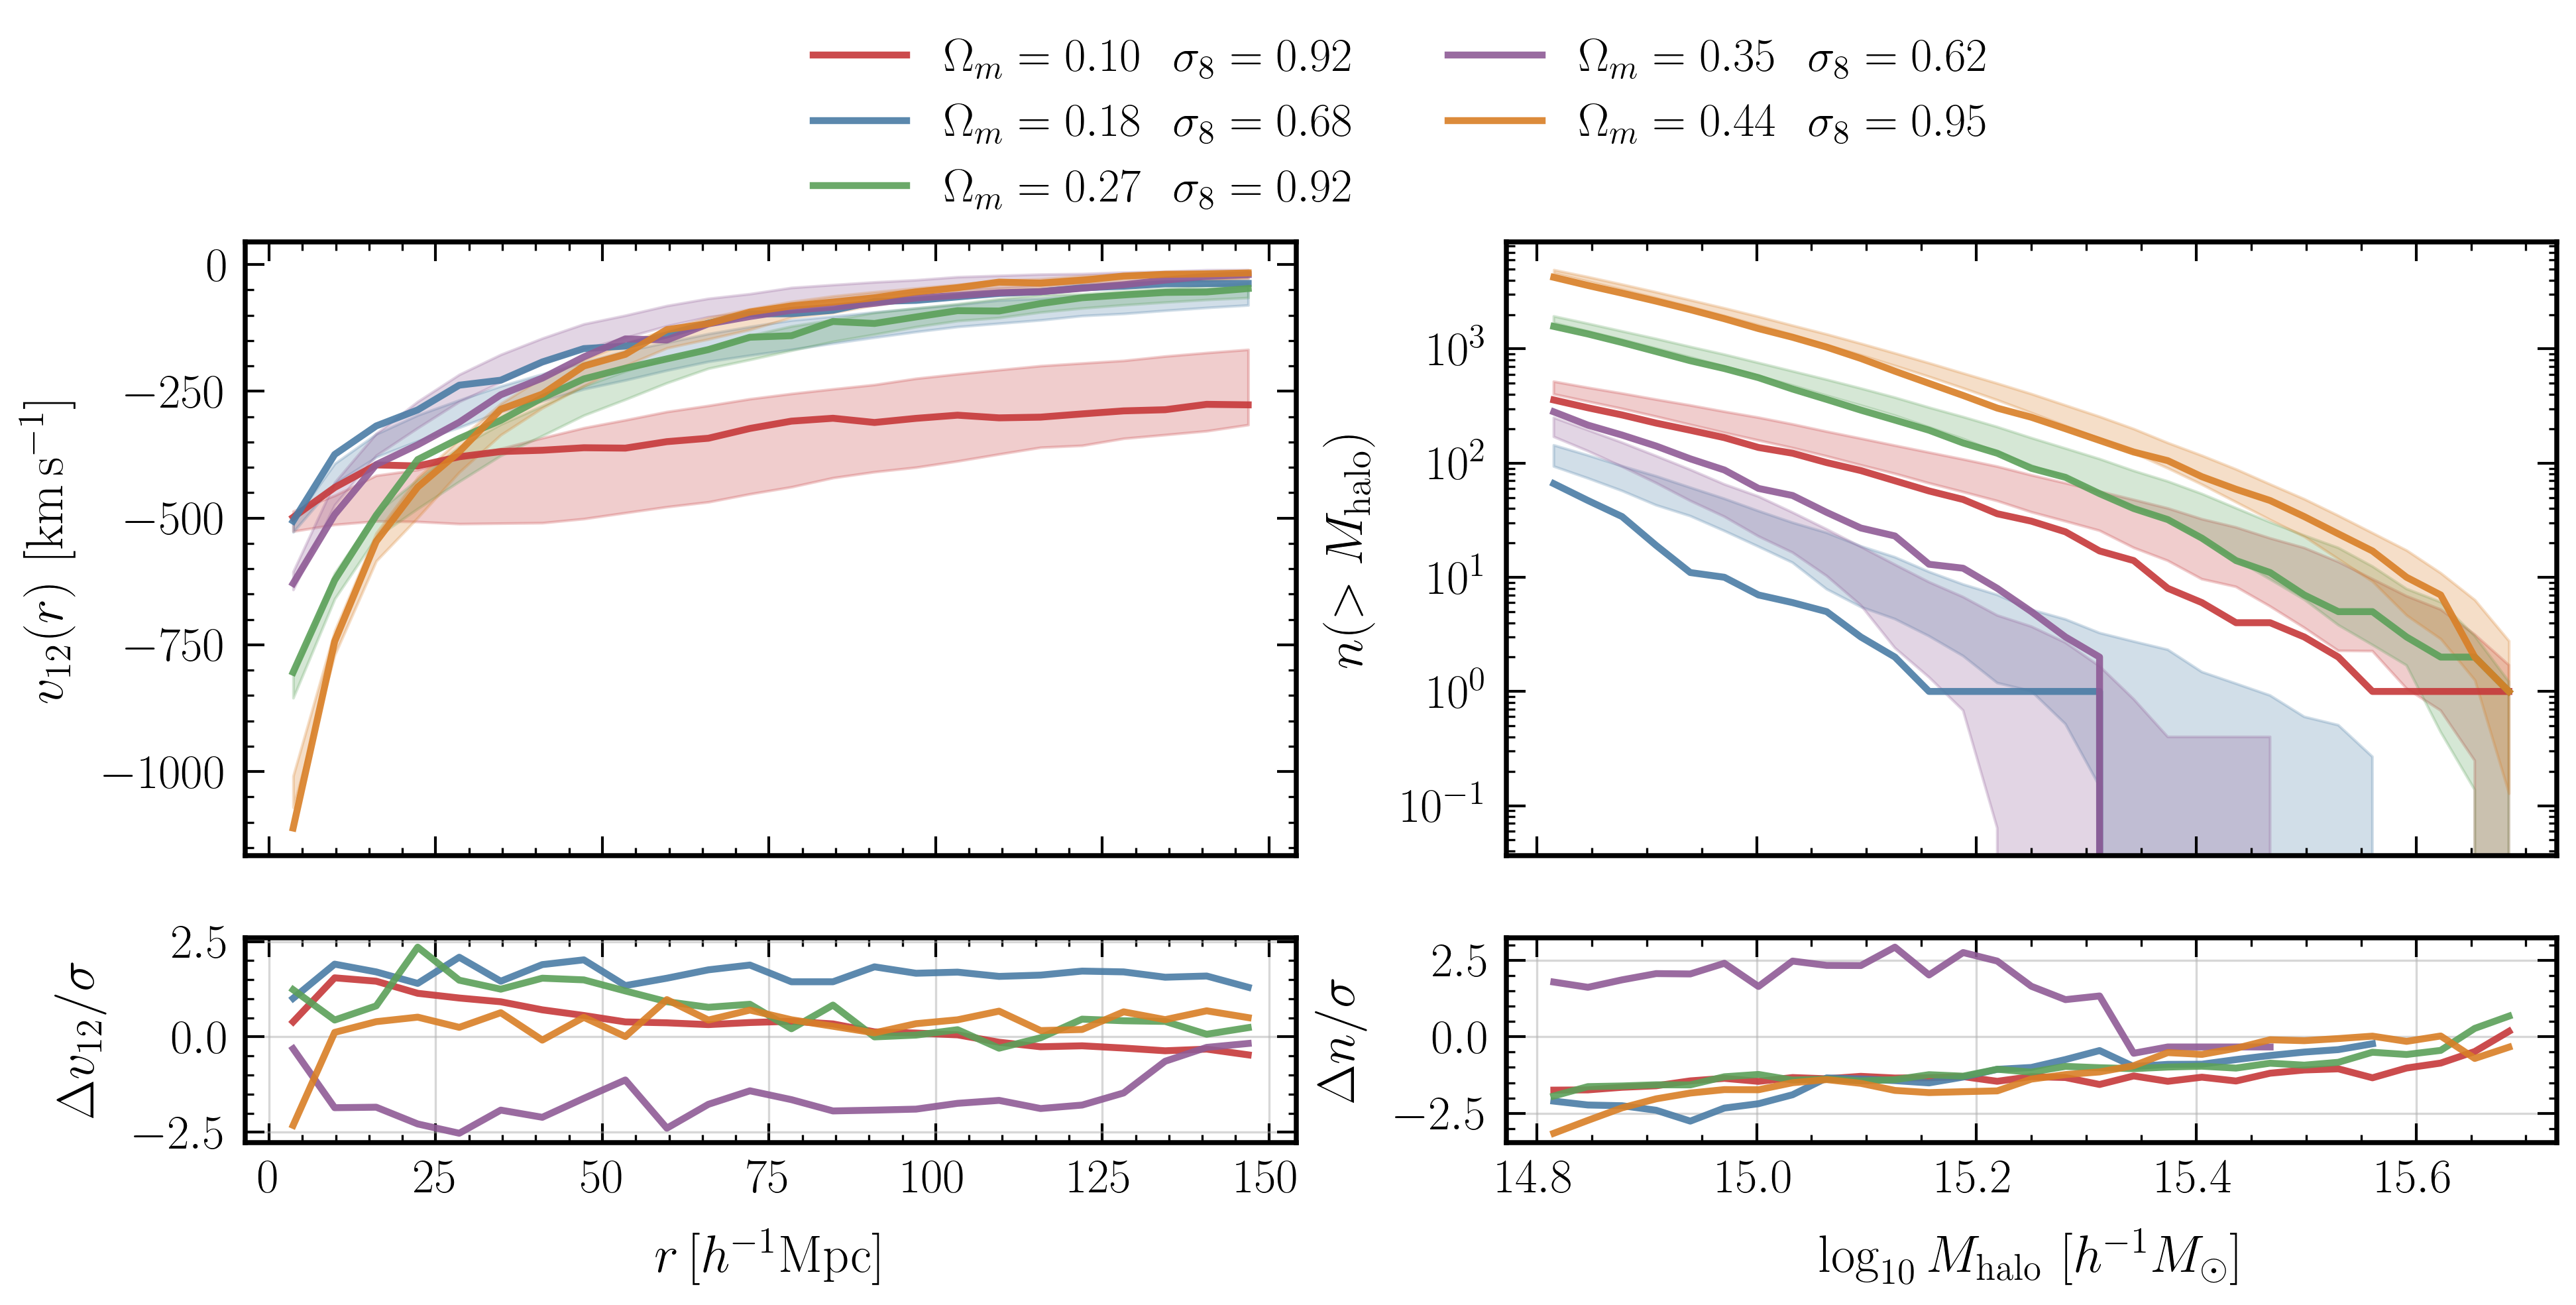

In [38]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex='col', gridspec_kw={'height_ratios': [3, 1],}, figsize=(15,6))# 'hspace':0.15},) 
mass_c = 0.5*(mass_bins[1:] + mass_bins[:-1])

for i, idx in enumerate(range(0,len(cosmologies), 4)):
    ax[0,0].fill_between(
        r_c, 
        (np.mean(test_gen_v12s[idx, :],axis=0) - np.std(test_gen_v12s[idx, :],axis=0)), 
        (np.mean(test_gen_v12s[idx, :],axis=0) + np.std(test_gen_v12s[idx, :],axis=0)), 
        alpha=0.25,
        color=colors[i],
    )
    ax[0,0].plot(r_c, test_v12s[idx], label= rf'$\Omega_m = {cosmologies[idx][0]:.2f} \, \, \, \, \sigma_8 = {cosmologies[idx][1]:.2f}$', color=colors[i],)# linestyle='dashed')
    ax[1,0].plot(r_c, (test_v12s[idx]-np.mean(test_gen_v12s[idx, :],axis=0))/np.std(test_gen_v12s[idx, :],axis=0))
ax[1,0].set_xlabel(r"$r\,[h^{-1}{\rm Mpc}]$")
ax[0,0].set_ylabel(r'$v_{12}(r) \,\, [\mathrm{km} \, \mathrm{s}^{-1}]$')
#ax[0,0].legend(bbox_to_anchor=(1.6,1.35),ncol=2)
ax[0,0].legend(bbox_to_anchor=(1.7,1.4),ncol=2)
ax[1,0].set_ylabel(r'$\Delta v_{12}/\sigma$')


for i, idx in enumerate(range(0,len(cosmologies), 4)):
    ax[0,1].fill_between(
        mass_c, 
        (np.mean(test_gen_hmfs[idx, :],axis=0) - np.std(test_gen_hmfs[idx, :],axis=0)), 
        (np.mean(test_gen_hmfs[idx, :],axis=0) + np.std(test_gen_hmfs[idx, :],axis=0)), 
        alpha=0.25,
        color=colors[i],
    )
    ax[0,1].plot(mass_c, test_hmfs[idx], label= rf'$\Omega_m = {cosmologies[idx][0]:.2f}$', color=colors[i],)# linestyle='dashed')
    ax[1,1].plot(mass_c, (test_hmfs[idx]-np.mean(test_gen_hmfs[idx, :],axis=0))/np.std(test_gen_hmfs[idx, :],axis=0), color=colors[i])

ax[1,0].grid(alpha=0.5)
ax[1,1].grid(alpha=0.5)
ax[0,1].set_yscale('log')
ax[1,1].set_xlabel(r'$\log_{10} M_{\rm halo} \,\,  [h ^{-1} M_{\odot}]$')
ax[0,1].set_ylabel(r'$ n( > M_{\rm halo})$')
ax[1,1].set_ylabel(r'$\Delta n /\sigma$')

plt.savefig('plots/velocity_parameter_variations.pdf', bbox_inches='tight', )